In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import nibabel as nib
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import sys
import os
import shutil
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
tick_size = 20
matplotlib.rcParams.update({
    'figure.figsize':(10,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif'
})

sns.set(rc={
    'figure.figsize':(10,10), 
    'font.size': 25, 
    "axes.labelsize":25, 
    "xtick.labelsize": tick_size, 
    "ytick.labelsize": tick_size,
    'font.family':'serif',
    'grid.linestyle': '',
    'axes.facecolor': 'white',
    'axes.edgecolor': '0.2',
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
})

palette = sns.color_palette("Set2", n_colors=6, desat=1)

In [3]:
def annot_figure(data, num_figs, lbound, class_mapping):
    
    pred = data[0][2]
    
    side = int(np.sqrt(num_figs))
    fig, axs = plt.subplots(
        side, 
        side,
    )
    
    plt.suptitle("Pred: {}".format(
                class_mapping[pred.argmax()],
            ),
                y = 0.925
        )
    
    c = 0
    for i in range(side):
        for j in range(side):
            img_path, slice_num, pred = data[c + lbound]
            
            axs[i, j].imshow(Image.open(img_path))
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            c += 1
     
    plt.show()
    plt.close()

In [4]:
MODEL_NAME = "phinet"
RESULTS_DIR = Path("results")
FIGURE_DIR = RESULTS_DIR / "figures"
GRADCAM_DIR = FIGURE_DIR / "gradcams"

        


In [5]:
subject_dirs = sorted([x for x in GRADCAM_DIR.iterdir()])


In [6]:
subject_dirs

[PosixPath('results/figures/gradcams/04-2951_1a_0501_FLAIR'),
 PosixPath('results/figures/gradcams/04-3434_1a_0501_FLAIR'),
 PosixPath('results/figures/gradcams/06-3830_2016-02-21_0026_POST_FLAIR_2D_BLADE_AX_3MM'),
 PosixPath('results/figures/gradcams/06-3910_2016-03-31_0025_POST_FLAIR_2D_BLADE_AX_3MM'),
 PosixPath('results/figures/gradcams/1756_1a_MR_POST'),
 PosixPath('results/figures/gradcams/3754_2001-01-01_0003_PREFLAIR_2D_BLADE_AX_3MM'),
 PosixPath('results/figures/gradcams/5833_1a_1201_FLAIRPOST'),
 PosixPath('results/figures/gradcams/7508633_2016-02-10_MPRAGE')]

In [7]:
# used in train, validation
dev_class_mapping = {
    0:"FL",
    1:"FLC",
    2:"PD",
    3:"T1",
    4:"T1C",
    5:"T2",
}

inv_dev_class_mapping = {v:k for k,v in dev_class_mapping.items()}

In [107]:
subject_dir = subject_dirs[0]

In [108]:
subject_dir

PosixPath('results/figures/gradcams/04-2951_1a_0501_FLAIR')

In [109]:
prob_path = subject_dir / "probabilities.csv"
df = pd.read_csv(prob_path)
img_paths = sorted([x for x in subject_dir.iterdir() if '.csv' not in x.suffixes])

In [110]:
def prob_vector_to_columns(row):
    fl, flc, pd_mod, t1, t1c, t2 = [np.float32(x) for x in row['probabilities'].split(' ')]
    return fl, flc, pd_mod, t1, t1c, t2

In [111]:
prob_columns = [k for k in inv_dev_class_mapping.keys()]
df[prob_columns] = df.apply(lambda row: prob_vector_to_columns(row), axis=1, result_type='expand')
df = df.drop('probabilities', axis=1)

In [112]:
# 0-236 sag
# 237-477 cor
# 478- ax

In [113]:
df.iloc[0:236][prob_columns].mean()

FL     0.021822
FLC    0.026017
PD     0.034788
T1     0.013686
T1C    0.885975
T2     0.016992
dtype: float64

In [114]:
df.iloc[237:477][prob_columns].mean()

FL     0.008958
FLC    0.010792
PD     0.011500
T1     0.006958
T1C    0.954083
T2     0.007875
dtype: float64

In [115]:
df.iloc[478:][prob_columns].mean()

FL     0.0
FLC    0.0
PD     0.0
T1     0.0
T1C    1.0
T2     0.0
dtype: float64

In [116]:
df = df.iloc[478:]
img_paths = img_paths[478:]

In [117]:
df.head()

slice number   FL  FLC   PD   T1  T1C   T2
478           478  0.0  0.0  0.0  0.0  1.0  0.0
479           479  0.0  0.0  0.0  0.0  1.0  0.0
480           480  0.0  0.0  0.0  0.0  1.0  0.0
481           481  0.0  0.0  0.0  0.0  1.0  0.0
482           482  0.0  0.0  0.0  0.0  1.0  0.0

In [118]:
conf_90 = []
conf_99 = []
unconf = []

for row, img_path in zip(df.iterrows(), img_paths):
    slice_num, *preds = row[1]
    preds = np.array(preds)
    if np.all(preds <= 0.5):
        unconf.append((img_path, slice_num, preds))
    if np.any(preds > 0.9):
        conf_90.append((img_path, slice_num, preds))
    if np.any(preds > 0.99):
        conf_99.append((img_path, slice_num, preds))


In [119]:
len(unconf), len(conf_90), len(conf_99), len(df)

(0, 141, 141, 141)

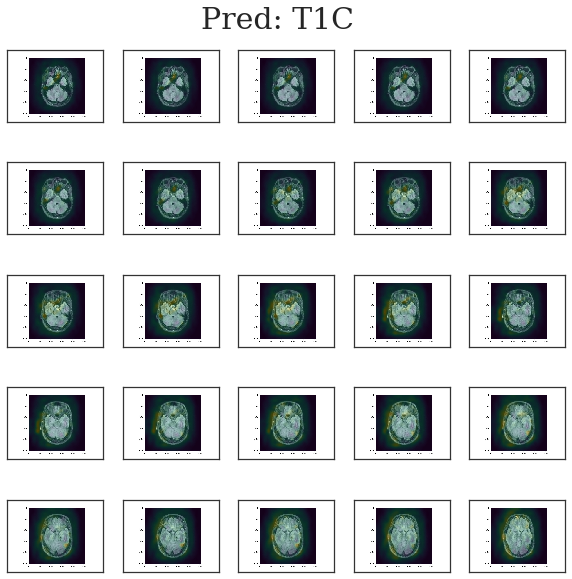

In [120]:
annot_figure(conf_99, 25, 30, dev_class_mapping)


In [85]:
for prob_column in prob_columns:
    print("{}\t{:.4f}".format(prob_column, df[prob_column].mean()))

FL	0.0120
FLC	0.0143
PD	0.0180
T1	0.0081
T1C	0.9377
T2	0.0097


# Checking intersections of training/testing filenames

In [475]:
DATA_DIR = Path("data")

In [476]:
train_filename_files = sorted([x for x in DATA_DIR.iterdir() if "train" in x.name])
val_filename_files = sorted([x for x in DATA_DIR.iterdir() if "val" in x.name])
test_filename_files = sorted([x for x in DATA_DIR.iterdir() if "labels" in x.name])

In [477]:
train_filename_files

[PosixPath('data/train_filenames_fold_0.txt'),
 PosixPath('data/train_filenames_fold_1.txt'),
 PosixPath('data/train_filenames_fold_2.txt'),
 PosixPath('data/train_filenames_fold_3.txt'),
 PosixPath('data/train_filenames_fold_4.txt')]

In [478]:
val_filename_files

[PosixPath('data/val_filenames_fold_0.txt'),
 PosixPath('data/val_filenames_fold_1.txt'),
 PosixPath('data/val_filenames_fold_2.txt'),
 PosixPath('data/val_filenames_fold_3.txt'),
 PosixPath('data/val_filenames_fold_4.txt')]

In [479]:
test_filename_files

[PosixPath('data/test_filenames_labels.txt')]

In [480]:
def get_fnames(filename_file):
    with open(filename_file) as f:
        fnames = [Path(l.strip().split(',')[0]).name for l in f.readlines()]
    return fnames

In [481]:
train_fnames = {}
val_fnames = {}
test_fnames = []

In [482]:
for fnames_dict, fname_file_folds in zip([train_fnames, val_fnames], [train_filename_files, val_filename_files]):
    for cur_fold, fname_file in enumerate(fname_file_folds):
        fnames_dict[cur_fold] = get_fnames(fname_file)

In [483]:
test_fnames = get_fnames(test_filename_files[0])

In [484]:
val_overlaps = []
# check if any validation files are in the test set
for cur_fold, fnames in val_fnames.items():
    for fname in fnames:
        if fname in test_fnames:
            val_overlaps.append(fname)

In [485]:
len(set(val_overlaps))

30

In [486]:
sorted(val_overlaps)

['2077917_2017-04-05_POST.nii.gz',
 '4142615_2015-04-16_POST.nii.gz',
 '4828896_2016-04-27_POST.nii.gz',
 '4888972_2015-06-16_POST.nii.gz',
 '4888972_2016-06-08_POST.nii.gz',
 '4981698_2016-11-14_POST.nii.gz',
 '7004564_2015-05-21_POST.nii.gz',
 '7046066_2014-09-22_POST.nii.gz',
 '7091011_2016-07-15_POST.nii.gz',
 '7092040_2017-01-25_POST.nii.gz',
 '7111472_2016-01-13_POST.nii.gz',
 '7170944_2017-06-30_POST.nii.gz',
 '7227024_2016-11-01_POST.nii.gz',
 '7227024_2017-05-12_POST.nii.gz',
 '7236517_2016-03-30_POST.nii.gz',
 '7236517_2017-04-12_POST.nii.gz',
 '7396363_2015-07-16_POST.nii.gz',
 '7401334_2016-04-08_POST.nii.gz',
 '7409059_2016-03-15_POST.nii.gz',
 '7415618_2015-07-28_POST.nii.gz',
 '7417172_2015-09-11_POST.nii.gz',
 '7463704_2016-08-17_CNRM.nii.gz',
 '7466705_2015-10-07_POST.nii.gz',
 '7488828_2015-11-10_POST.nii.gz',
 '7510974_2016-02-10_POST.nii.gz',
 '7510986_2016-02-12_POST.nii.gz',
 '7541338_2017-01-25_POST.nii.gz',
 '7588094_2016-07-26_CNRM.nii.gz',
 '7609164_2016-09-08

In [487]:
train_overlaps = []
# check if any training files are in the test set
for cur_fold, fnames in train_fnames.items():
    for fname in fnames:
        if fname in test_fnames:
            train_overlaps.append(fname)

In [488]:
len(set(train_overlaps))

30

In [489]:
sorted(set(train_overlaps)) == sorted(val_overlaps)

True

In [490]:
# These files should be omitted in final analysis ^

In [491]:
testing_pred_paths

[PosixPath('results/test_metrics_on_nifti_ALL_DATA_fold_0.csv'),
 PosixPath('results/test_metrics_on_nifti_ALL_DATA_fold_1.csv'),
 PosixPath('results/test_metrics_on_nifti_ALL_DATA_fold_2.csv'),
 PosixPath('results/test_metrics_on_nifti_ALL_DATA_fold_3.csv'),
 PosixPath('results/test_metrics_on_nifti_ALL_DATA_fold_4.csv')]

In [24]:
cur_fold = 0

In [25]:
with open(str(testing_pred_paths[cur_fold])) as f:
    lines = [l.strip().split(',') for l in f.readlines()]

In [29]:
lines[1]

['/ISFILE3/USERS/remediossw/phinet/data/preprocess/T1C/03-3783_1a_MR_POST.nii.gz',
 '5',
 '4',
 '[0.03 0.01 0.00 0.00 0.95 0.01 ]']

In [32]:
df = pd.DataFrame(lines[1:], columns=lines[0])

In [33]:
df.head()

filename true_class pred_class  \
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...          5          4   
1  /ISFILE3/USERS/remediossw/phinet/data/preproce...          1          3   
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...          4          0   
3  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0          5   
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0          5   

                         pred_score  
0  [0.03 0.01 0.00 0.00 0.95 0.01 ]  
1  [0.00 0.00 0.00 0.99 0.00 0.01 ]  
2  [0.83 0.04 0.04 0.04 0.01 0.06 ]  
3  [0.00 0.00 0.01 0.04 0.01 0.94 ]  
4  [0.01 0.00 0.00 0.01 0.00 0.97 ]

In [198]:
df = df[['filename', 'true_class', 'pred_class']]

In [199]:
len(df)

6910

In [200]:
df = df.dropna()

In [201]:
len(df)

4144

In [202]:
df.head()

filename true_class pred_class
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...          5          4
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...          1          3
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...          4          0
5  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0          5
7  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0          5

In [34]:
def row_to_true_class(fname, class_mapping):
    return class_mapping[Path(fname).parent.name]

In [35]:
df['true_class'] = df['filename'].apply(lambda row: row_to_true_class(row, inv_dev_class_mapping))

In [36]:
df.head()

filename  true_class pred_class  \
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...           4          4   
1  /ISFILE3/USERS/remediossw/phinet/data/preproce...           3          3   
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...           0          0   
3  /ISFILE3/USERS/remediossw/phinet/data/preproce...           5          5   
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...           5          5   

                         pred_score  
0  [0.03 0.01 0.00 0.00 0.95 0.01 ]  
1  [0.00 0.00 0.00 0.99 0.00 0.01 ]  
2  [0.83 0.04 0.04 0.04 0.01 0.06 ]  
3  [0.00 0.00 0.01 0.04 0.01 0.94 ]  
4  [0.01 0.00 0.00 0.01 0.00 0.97 ]

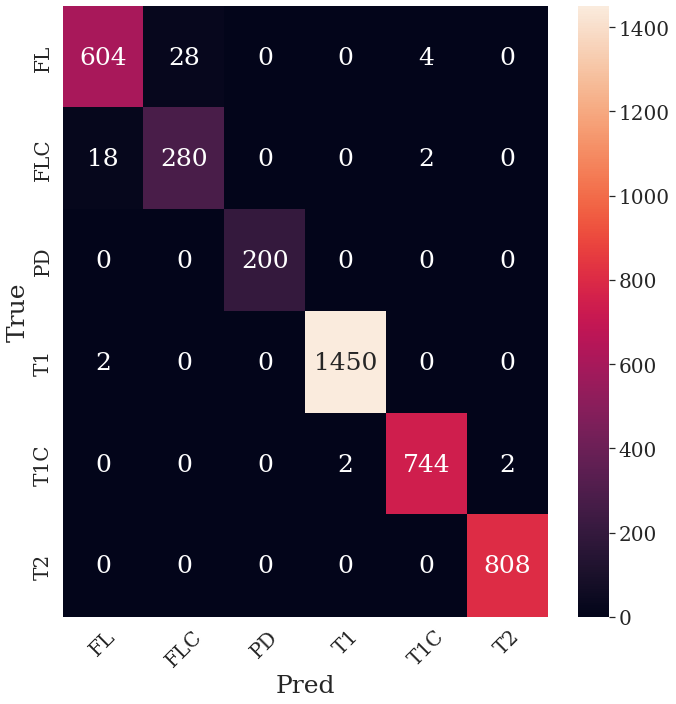

In [37]:
##### CONFUSION MATRIX #####

cm_df = pd.DataFrame(confusion_matrix(
    df['true_class'].astype(int), 
    df['pred_class'].astype(int))
)
sns.heatmap(cm_df, annot=True, fmt='g')
plt.xlabel('Pred')
plt.ylabel('True')
plt.tight_layout()
plt.xticks(np.arange(len(dev_class_mapping))+0.5, list(dev_class_mapping.values()), rotation=45, ha='center')
plt.yticks(np.arange(len(dev_class_mapping))+0.5, list(dev_class_mapping.values()), va='center')
plt.savefig(FIGURE_DIR / "confusion_matrix_fold_{}.png".format(cur_fold))
plt.show()
plt.close()

In [92]:
print("{}/{} = {:.2%} accuracy".format(
    np.diag(cm_df).sum(),
    np.array(cm_df).sum(),
    np.diag(cm_df).sum() / np.array(cm_df).sum(),
))

4100/4144 = 98.94% accuracy


# Ensemble - Majority Voting

In [492]:
with open("data/test_filenames_labels.txt", 'r') as f:
    lines = [l.strip().split(',') for l in f.readlines()]

In [493]:
ensemble_df = pd.DataFrame(lines, columns=['filename', 'true_class'])

In [494]:
ensemble_df.head()

filename true_class
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...          5
1  /ISFILE3/USERS/remediossw/phinet/data/preproce...          1
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...          4
3  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0

In [495]:
for cur_fold in range(5):
    with open(str(testing_pred_paths[cur_fold])) as f:
        lines = [l.strip().split(',') for l in f.readlines()]
    df = pd.DataFrame(lines[1:], columns=lines[0])
    ensemble_df['fold_{}_pred_class'.format(cur_fold)] = df['pred_class'].copy()


## Removing duplicates

In [496]:
def add_parent(fname):
    parent = Path("/ISFILE3/USERS/remediossw/phinet")
    
    if fname.root != '/':
        return parent / fname
    return fname

In [498]:
unique_names = [str(l) for l in set(ensemble_df['filename'].apply(lambda f: add_parent(Path(f))))]

In [499]:
ensemble_df = ensemble_df[ensemble_df['filename'].isin(unique_names)]

In [500]:
len(ensemble_df)

2072

In [501]:
def ensemble_prediction(row):
    preds = ['fold_{}_pred_class'.format(i) for i in range(4)]
    mode_class = row[preds].dropna().astype(int).mode()
    if len(mode_class) < 1:
        impute_value= np.nan
    else:
        impute_value = int(row[preds].dropna().astype(int).mode()[0])
    return impute_value

In [502]:
ensemble_df.head()

filename true_class  \
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...          5   
1  /ISFILE3/USERS/remediossw/phinet/data/preproce...          1   
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...          4   
3  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0   
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0   

  fold_0_pred_class fold_1_pred_class fold_2_pred_class fold_3_pred_class  \
0                 4                 4                 4                 4   
1                 3                 3                 3                 3   
2                 0                 0                 0                 0   
3                 5                 5                 5                 5   
4                 5                 5                 5                 5   

  fold_4_pred_class  
0                 4  
1                 3  
2                 0  
3                 5  
4                 5

In [503]:
ensemble_df['ensemble_pred'] = ensemble_df.apply(lambda row: ensemble_prediction(row), axis=1)

In [504]:
ensemble_df.head()

filename true_class  \
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...          5   
1  /ISFILE3/USERS/remediossw/phinet/data/preproce...          1   
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...          4   
3  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0   
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...          0   

  fold_0_pred_class fold_1_pred_class fold_2_pred_class fold_3_pred_class  \
0                 4                 4                 4                 4   
1                 3                 3                 3                 3   
2                 0                 0                 0                 0   
3                 5                 5                 5                 5   
4                 5                 5                 5                 5   

  fold_4_pred_class  ensemble_pred  
0                 4              4  
1                 3              3  
2                 0              0  
3                 5              5  
4                 5              5

In [505]:
len(ensemble_df)

2072

In [506]:
ensemble_df = ensemble_df.dropna(subset=['ensemble_pred'])

In [507]:
len(ensemble_df)

2072

In [508]:
ensemble_df['true_class'] = ensemble_df['filename'].apply(lambda row: row_to_true_class(row, inv_dev_class_mapping))

In [509]:
ensemble_df.head()

filename  true_class  \
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...           4   
1  /ISFILE3/USERS/remediossw/phinet/data/preproce...           3   
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...           0   
3  /ISFILE3/USERS/remediossw/phinet/data/preproce...           5   
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...           5   

  fold_0_pred_class fold_1_pred_class fold_2_pred_class fold_3_pred_class  \
0                 4                 4                 4                 4   
1                 3                 3                 3                 3   
2                 0                 0                 0                 0   
3                 5                 5                 5                 5   
4                 5                 5                 5                 5   

  fold_4_pred_class  ensemble_pred  
0                 4              4  
1                 3              3  
2                 0              0  
3                 5              5  
4                 5              5

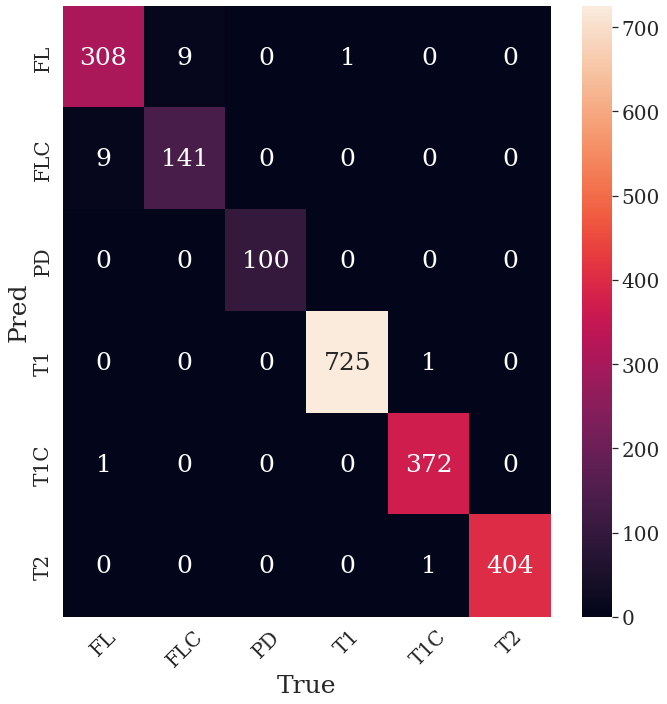

In [510]:
##### CONFUSION MATRIX #####

cm_df = pd.DataFrame(confusion_matrix(
    ensemble_df['ensemble_pred'].astype(int),
    ensemble_df['true_class'].astype(int), 
))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.xlabel('True')
plt.ylabel('Pred')
plt.tight_layout()
plt.xticks(np.arange(len(dev_class_mapping))+0.5, list(dev_class_mapping.values()), rotation=45, ha='center')
plt.yticks(np.arange(len(dev_class_mapping))+0.5, list(dev_class_mapping.values()), va='center')
plt.savefig(FIGURE_DIR / "confusion_matrix_fold_{}.png".format(cur_fold))
plt.show()
plt.close()

In [511]:
print("{}/{} = {:.2%} accuracy".format(
    np.diag(cm_df).sum(),
    np.array(cm_df).sum(),
    np.diag(cm_df).sum() / np.array(cm_df).sum(),
))

2050/2072 = 98.94% accuracy


# Examining Errors

In [512]:
ensemble_df.head()

filename  true_class  \
0  /ISFILE3/USERS/remediossw/phinet/data/preproce...           4   
1  /ISFILE3/USERS/remediossw/phinet/data/preproce...           3   
2  /ISFILE3/USERS/remediossw/phinet/data/preproce...           0   
3  /ISFILE3/USERS/remediossw/phinet/data/preproce...           5   
4  /ISFILE3/USERS/remediossw/phinet/data/preproce...           5   

  fold_0_pred_class fold_1_pred_class fold_2_pred_class fold_3_pred_class  \
0                 4                 4                 4                 4   
1                 3                 3                 3                 3   
2                 0                 0                 0                 0   
3                 5                 5                 5                 5   
4                 5                 5                 5                 5   

  fold_4_pred_class  ensemble_pred  
0                 4              4  
1                 3              3  
2                 0              0  
3                 5              5  
4                 5              5

In [513]:
error_df = ensemble_df[ensemble_df['true_class'] != ensemble_df['ensemble_pred']]

In [514]:
len(error_df)

22

In [515]:
error_df.head()

filename  true_class  \
171  /ISFILE3/USERS/remediossw/phinet/data/preproce...           3   
174  /ISFILE3/USERS/remediossw/phinet/data/preproce...           4   
381  /ISFILE3/USERS/remediossw/phinet/data/preproce...           1   
450  /ISFILE3/USERS/remediossw/phinet/data/preproce...           0   
468  /ISFILE3/USERS/remediossw/phinet/data/preproce...           1   

    fold_0_pred_class fold_1_pred_class fold_2_pred_class fold_3_pred_class  \
171                 0                 0                 0                 0   
174                 5                 5                 5                 5   
381                 0                 0                 0                 0   
450                 1                 1                 1                 1   
468                 0                 0                 0                 0   

    fold_4_pred_class  ensemble_pred  
171                 0              0  
174                 5              5  
381                 0              0  
450                 1              1  
468                 0              0

In [516]:
def get_spaced_slices(num_slices, num_plots, offset):
    t = (num_slices-(offset*2)) // num_plots
    return [x for x in range(offset, num_slices-offset, t)]

In [552]:
def annot_figure(row, num_figs, offset, class_mapping, fig_dir):
    x = nib.load(row['filename']).get_fdata()
    
    side = int(np.sqrt(num_figs))
    fig, axs = plt.subplots(
        side, 
        side,
    )
    

    plt.suptitle("True: {} | Pred: {}".format(
                class_mapping[row['true_class']],
                class_mapping[row['ensemble_pred']],
            ),
                y = 0.925
        )
    
    spaced_slices = get_spaced_slices(x.shape[-1], num_figs, offset)
    c = 0
    for i in range(side):
        for j in range(side):
            axs[i, j].imshow(x[:, :, spaced_slices[c]].T, cmap='Greys_r', vmin=0.0, vmax=255.0)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            c += 1
            
    details_str = "Image details\nShape: {}\nMax: {:.2f}\nMin: {:.2f}\nMean: {:.2f}".format(
        x.shape, x.max(), x.min(), x.mean()
    )
            
    plt.text(
        -1.2, 0.0, 
        details_str, 
        fontsize=16,
        horizontalalignment='center',
        verticalalignment='center', 
        transform=axs[0,0].transAxes
    )
    
    gap = 1e-4
    plt.subplots_adjust(wspace=gap, hspace=gap)
    
    fig_class_dir = fig_dir / dev_class_mapping[row['true_class']]
    if not fig_class_dir.exists():
        fig_class_dir.mkdir(parents=True)

    figure_name = fig_class_dir / "annotated_montage_{}.png".format(Path(row['filename']).stem.split('.')[0])
    #plt.savefig(figure_name, bbox_inches="tight")
    plt.show()
    plt.close()

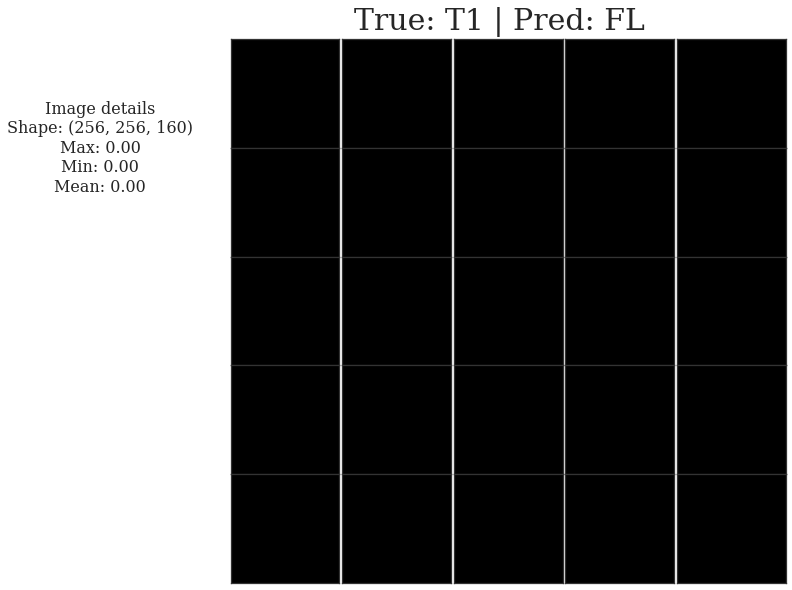

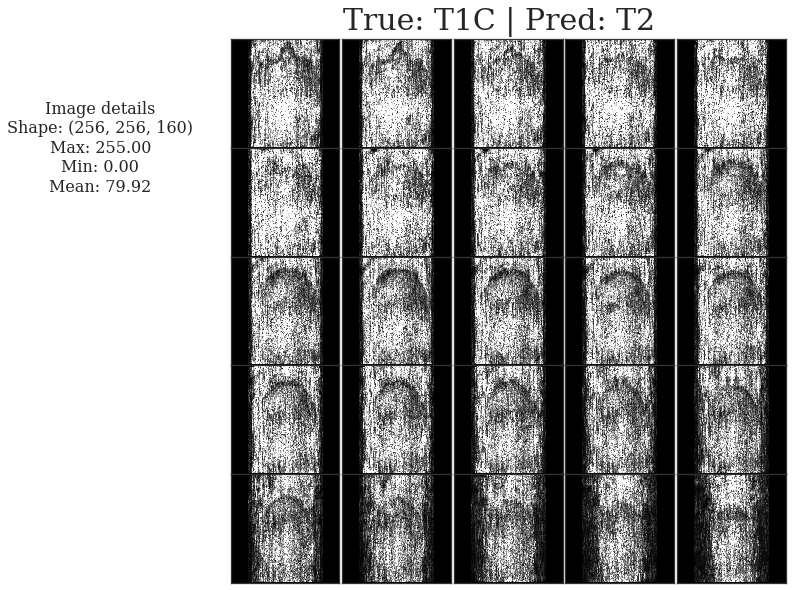

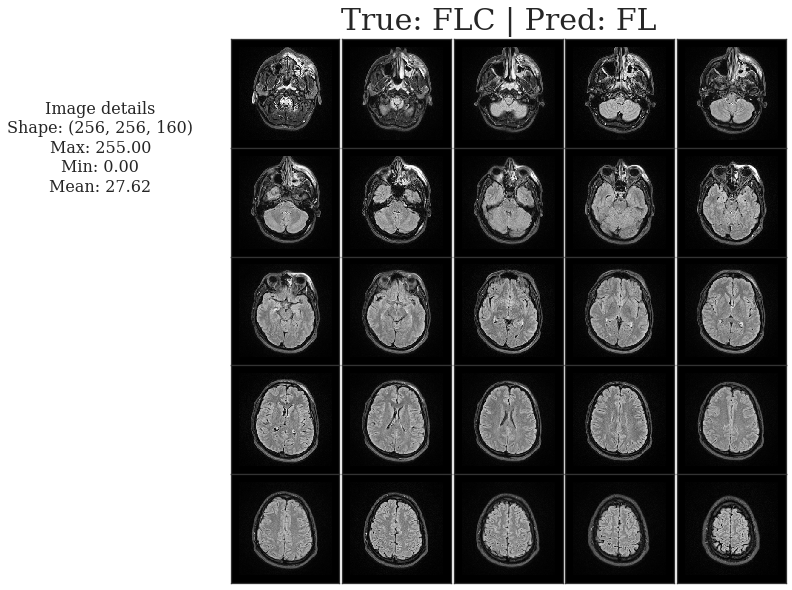

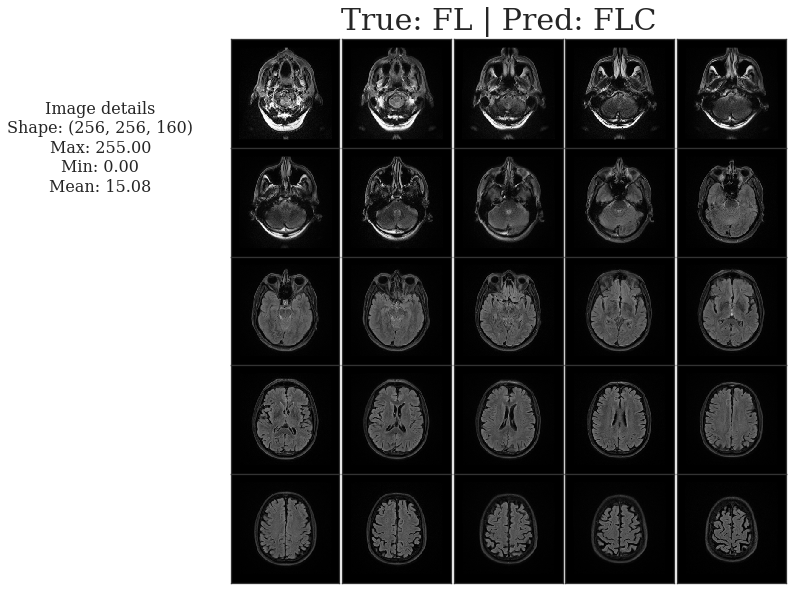

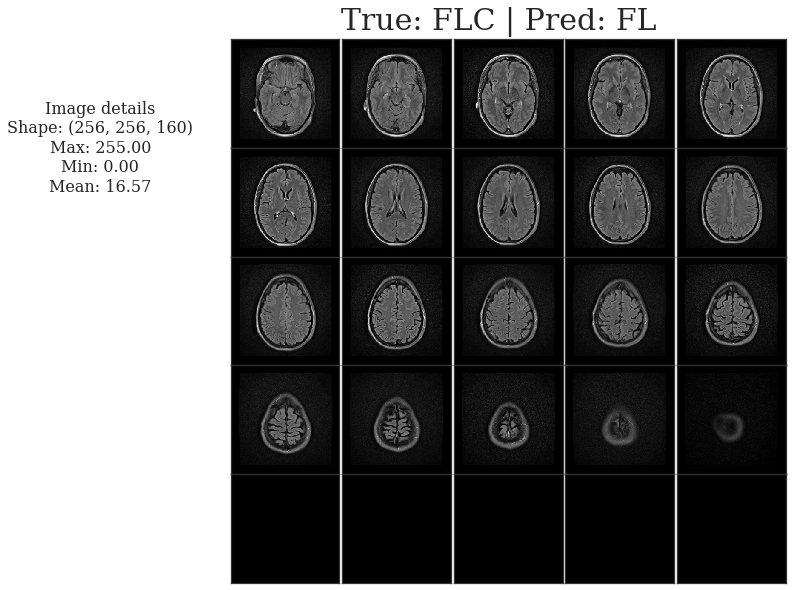

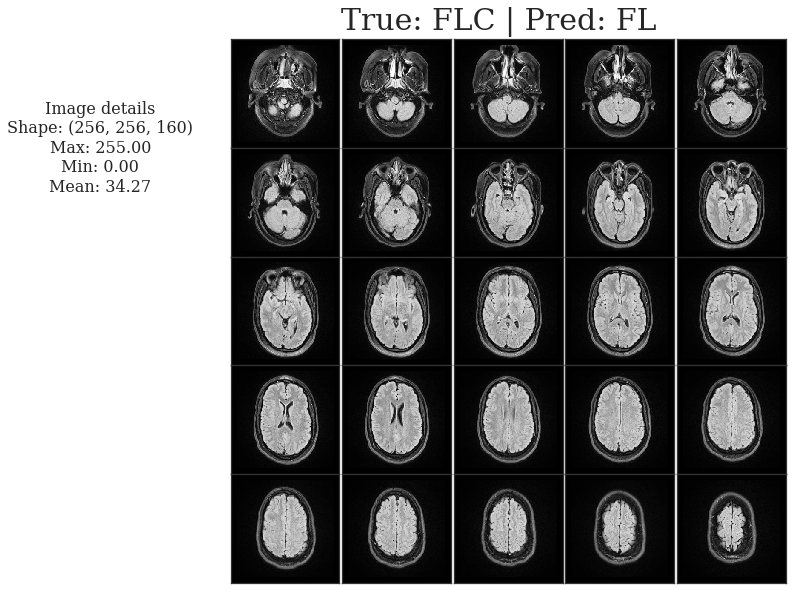

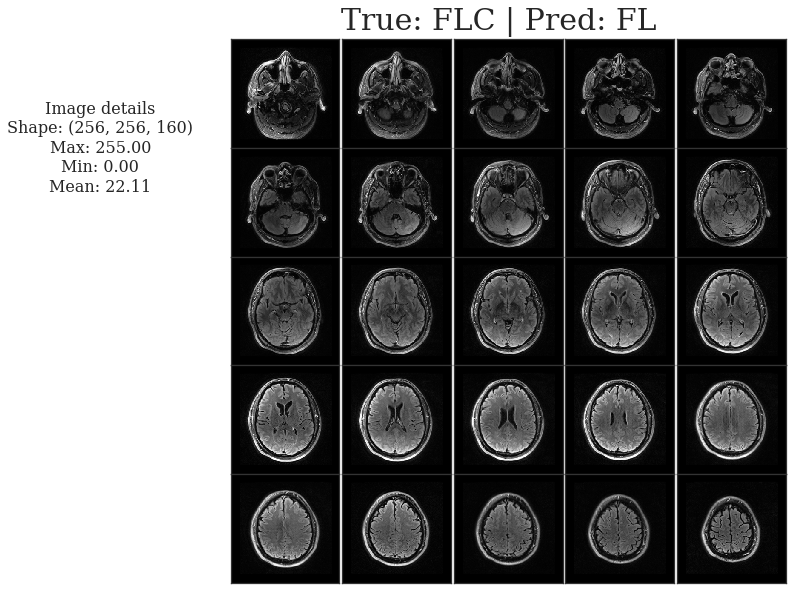

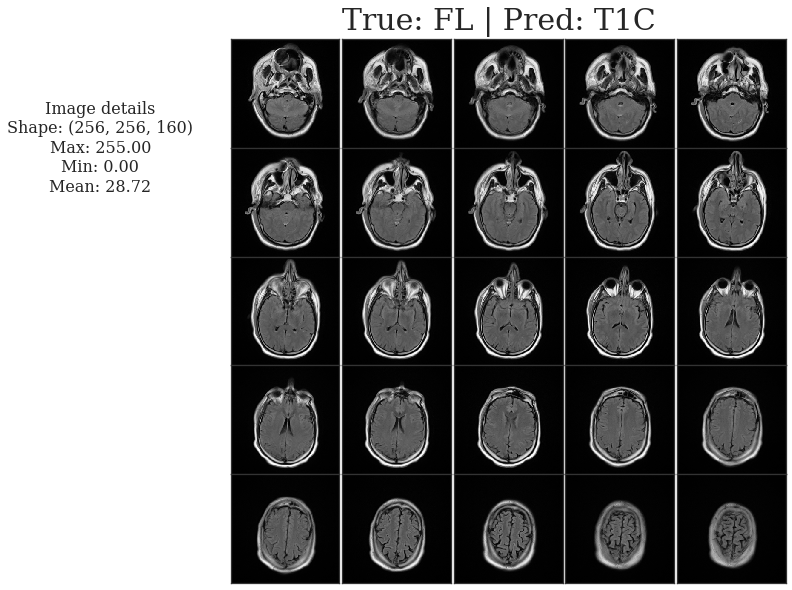

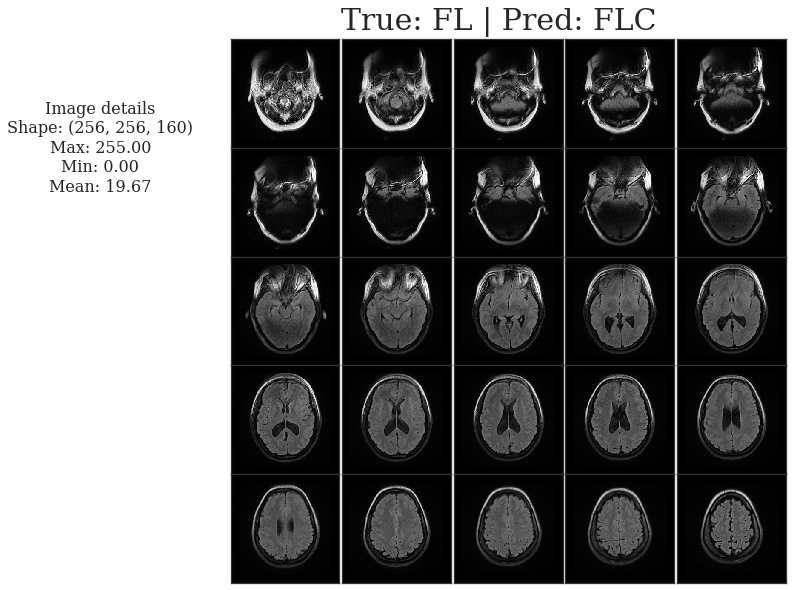

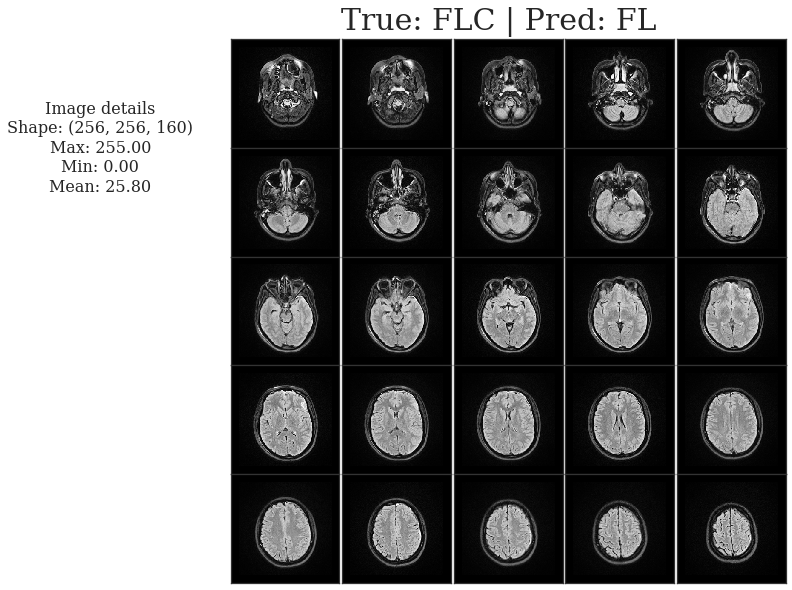

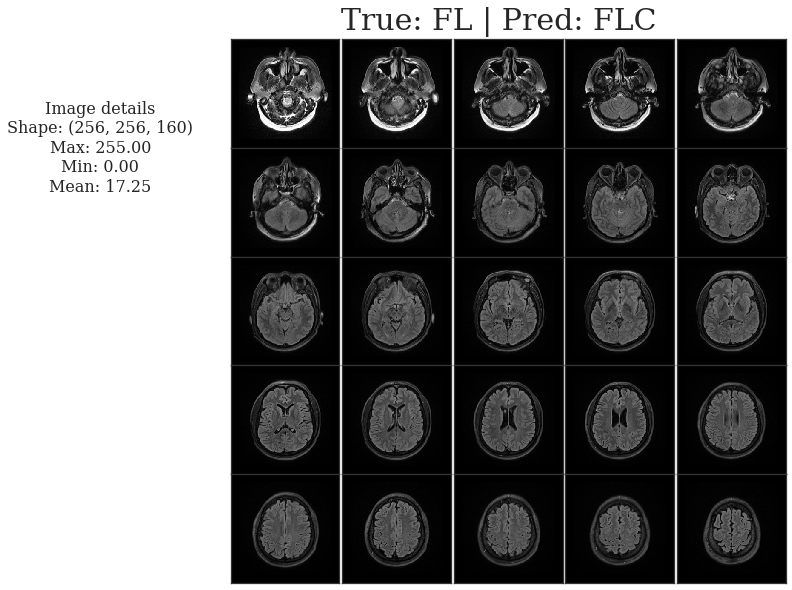

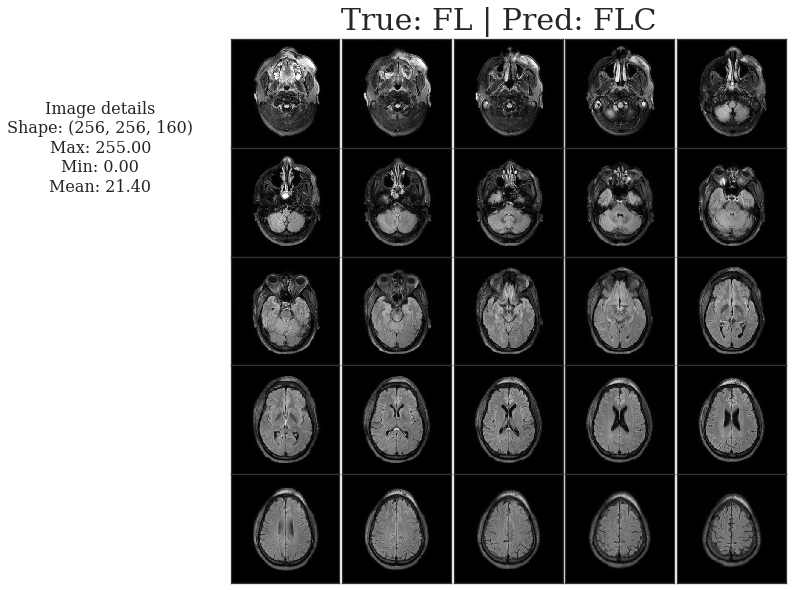

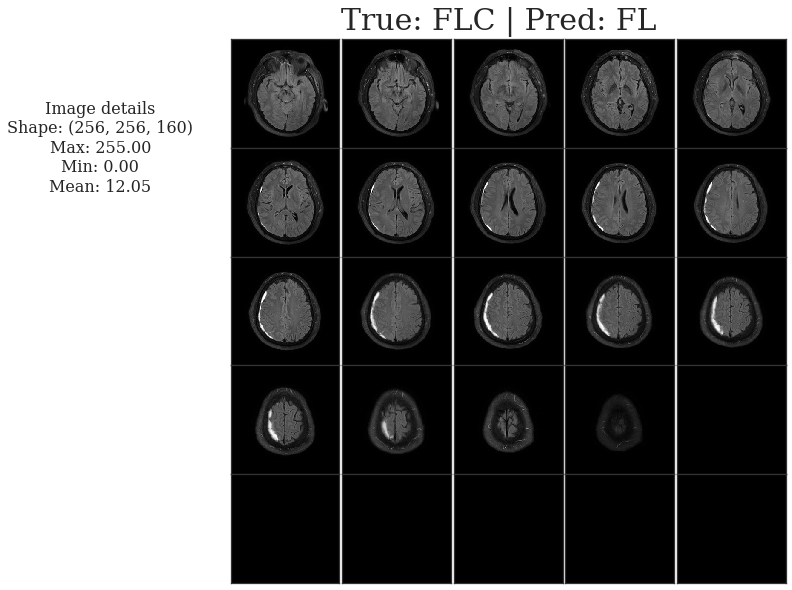

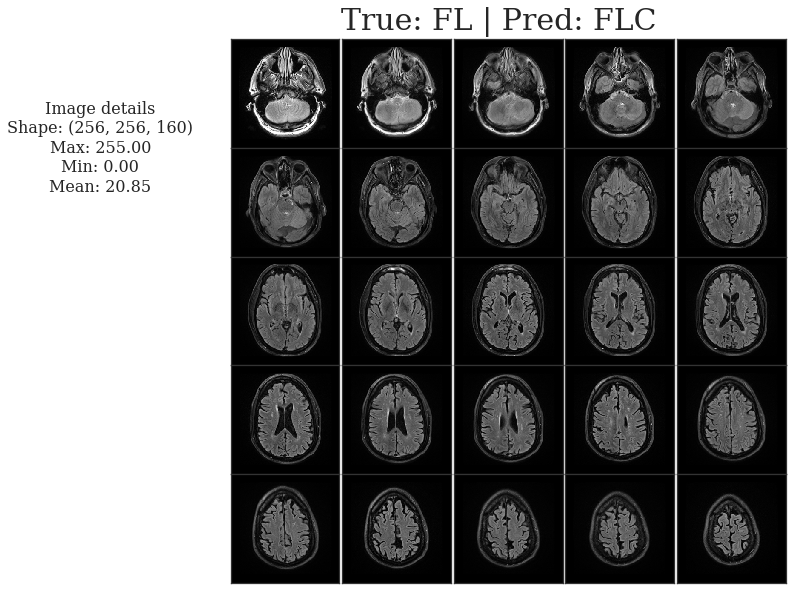

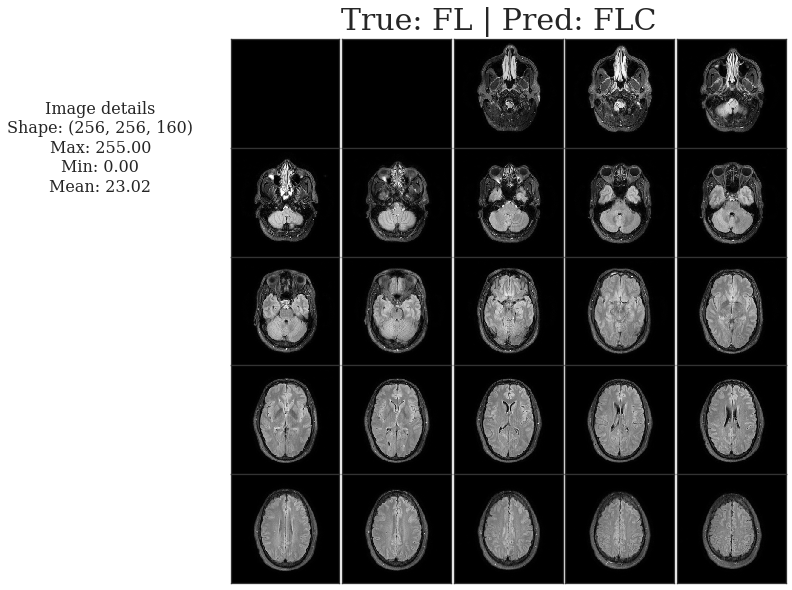

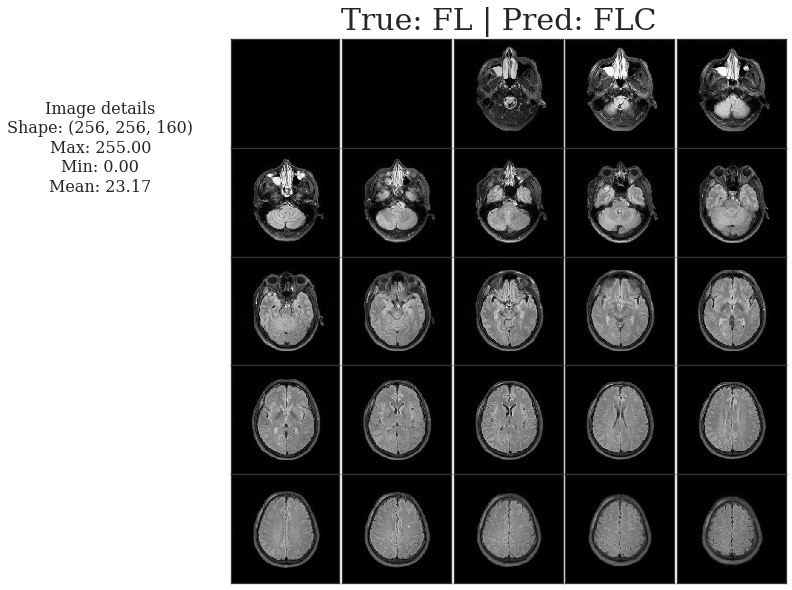

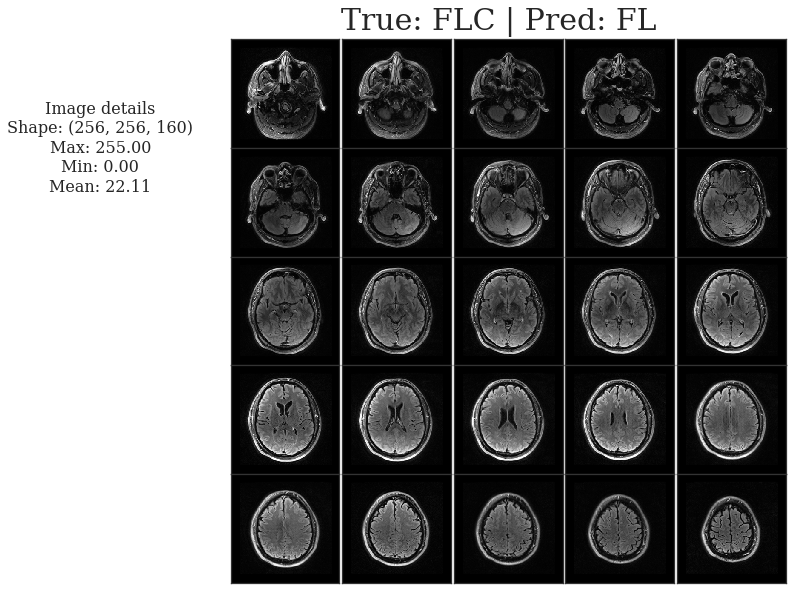

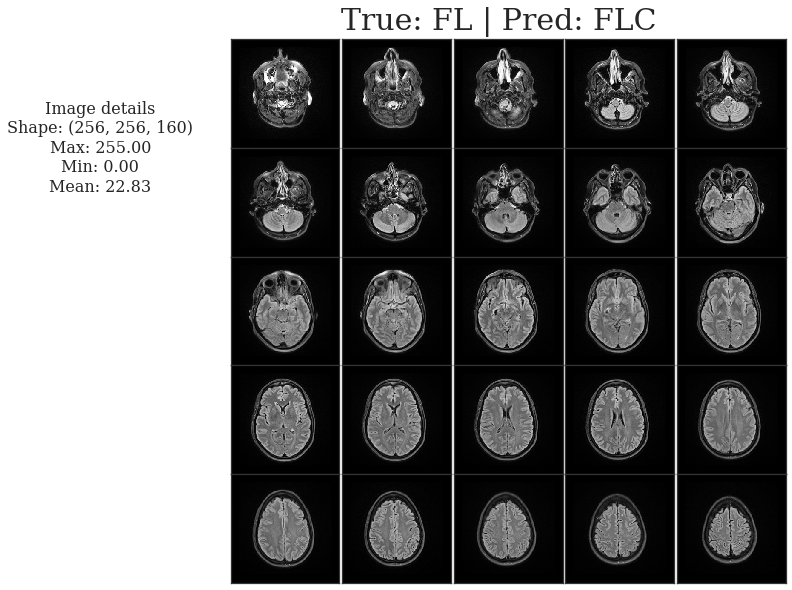

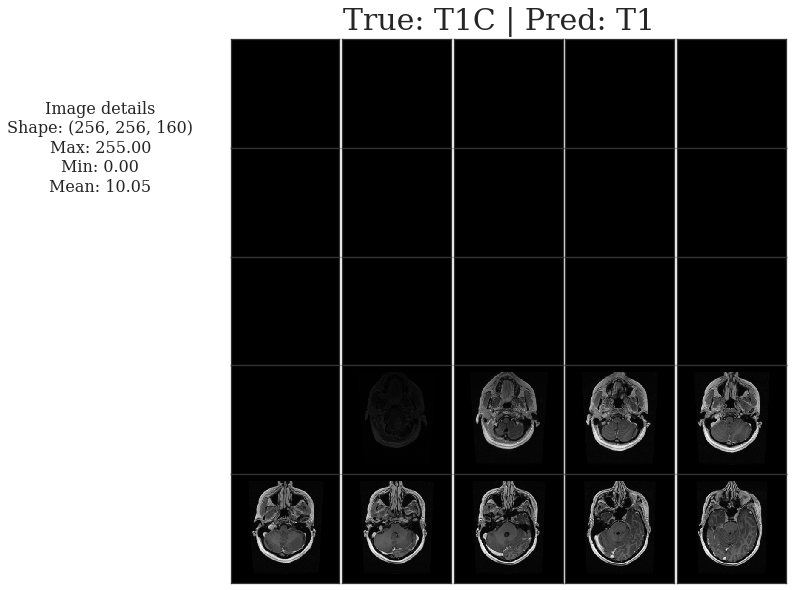

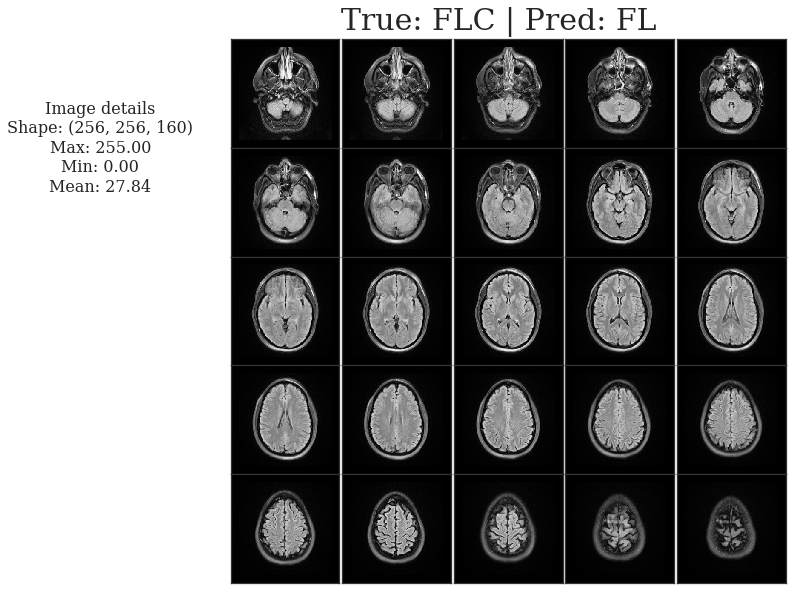

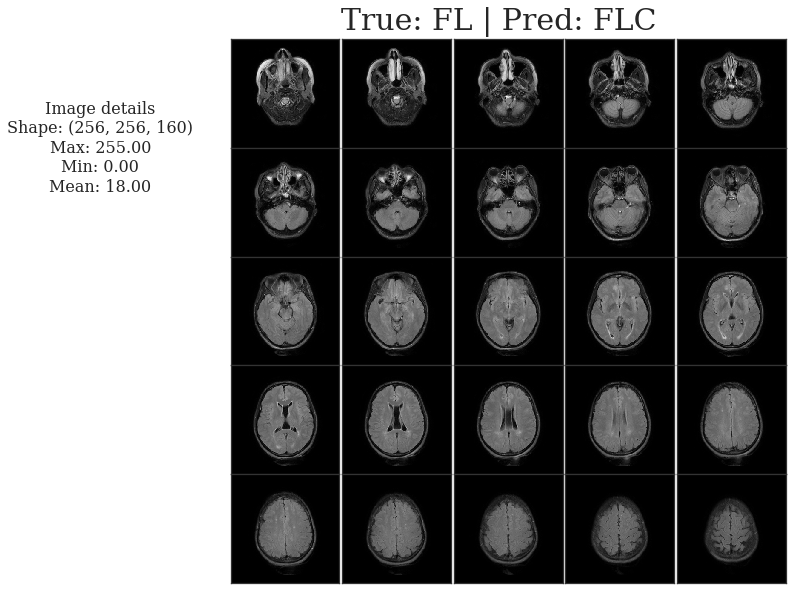

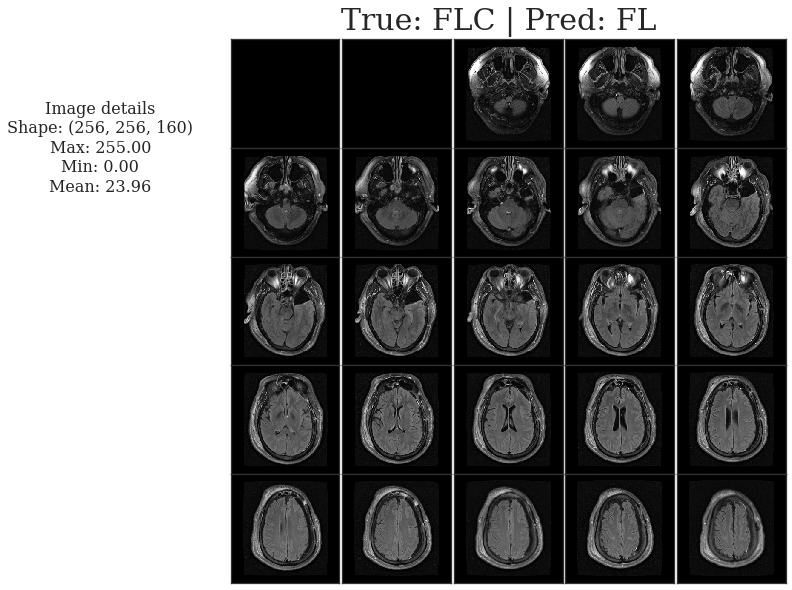

In [541]:
for row in error_df.iterrows():
    annot_figure(row[1], 25, 10, dev_class_mapping, ERROR_DIR)

In [526]:
f = error_df[error_df['true_class']==3]['filename']

In [531]:
f.iloc[0]

'/ISFILE3/USERS/remediossw/phinet/data/preprocess/T1/1707_30d_MR_T1.nii.gz'

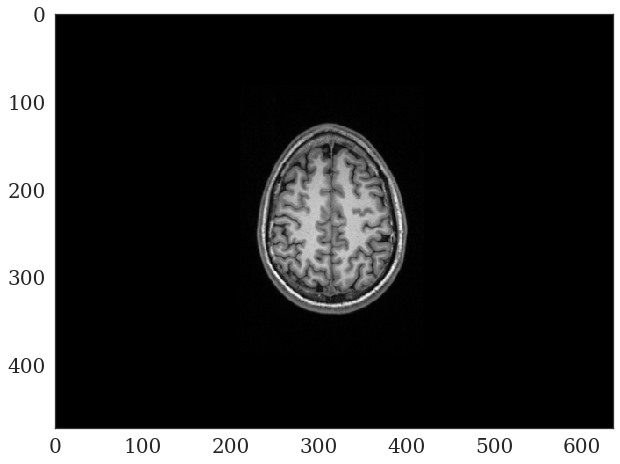

In [539]:
f = nib.load("/ISFILE3/USERS/remediossw/phinet/data/T1/1707_30d_MR_T1.nii.gz").get_fdata()
plt.imshow(f[:, :, 100].T, cmap='Greys_r')